# Explore and Manipulate Dataset

## File locations
Just enter in the relative (from this notebook file) location of the LISA dataset folder, and output data folder.

In [2]:
# Relative location of LISA files directory
lisa_location = 'data'

# Relative location of final organized data
data_location = 'darknet2'

## Load and show some annotations
Load in annotations and show structure so that we can parse.

In [3]:
from os.path import join   
    
# Load csv file
with open(join(lisa_location, 'allAnnotations.csv'), 'r') as f:
    csv = f.readlines()

annotations = []
for line in csv:
    cells = line.split(',')
    annotation = []
    for cell in cells:
        annotation += cell.strip().split(';')
    annotations.append(annotation)

headers = annotations[0]
annotations = annotations[1:]
num_annotations = len(annotations)

# Get all unique classes
classes = set()
for annotation in annotations:
    classes.add(annotation[1])
classes = sorted(list(classes))
num_classes = len(classes)

print(f'{num_classes} classes found.')
print(f'{num_annotations} total annotations.')
print('Annotation Headers:', headers)
print('Example Annotation:', annotations[0])

47 classes found.
7855 total annotations.
Annotation Headers: ['Filename', 'Annotation tag', 'Upper left corner X', 'Upper left corner Y', 'Lower right corner X', 'Lower right corner Y', 'Occluded', 'On another road', 'Origin file', 'Origin frame number', 'Origin track', 'Origin track frame number']
Example Annotation: ['aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/stop_1330545910.avi_image0.png', 'stop', '862', '104', '916', '158', '0', '0', 'aiua120214-0/DataLog02142012_external_camera.avi', '2667', 'stop_1330545910.avi', '2']


## Format Annotations
Define a class to help us format the annotations and work with their corresponding files. This class will format the annotations in YOLO format, modify it to work with whatever format you desire.

In [5]:
from PIL import Image
from os.path import join

class Annotation:
    def __init__(self, annotation_list):
        # Take in annotation lists generated above, and create fields
        self.filename = join(lisa_location, annotation_list[0])
        self.label = annotation_list[1]
        
        # You will likely need to modify the method here, which takes in
        # bounding box location and size of format 
        # [Upper Left X, Upper Left Y, Lower Right X, Lower Right Y]
        self.bounds = self.parse_bounds(annotation_list[2:6])
        
    def parse_bounds(self, bounds):
        # This method parses the location from the annotation into a format used for YOLO
        UL_x = float(bounds[0])
        UL_y = float(bounds[1])
        LR_x = float(bounds[2])
        LR_y = float(bounds[3])
        
        # Yolo takes in bounding box location of format:
        # [Center X, Center Y, Width, Height]
        # all normalized by width and height of image
        im = Image.open(self.filename)
        im_width, im_height = im.size
        
        box_width = LR_x - UL_x
        box_height = LR_y - UL_y
        box_x = UL_x + box_width/2
        box_y = UL_y + box_height/2
        
        # Return bounding box location and size
        return [box_x/im_width, box_y/im_height, box_width/im_width, box_height/im_height]
    
    def __str__(self):
        # String format of [label index, x, y, width, height] for creating label txt file
        label = classes.index(self.label)
        return f'{label} {self.bounds[0]} {self.bounds[1]} {self.bounds[2]} {self.bounds[3]}'
    

# Generate formatted list of annotations
formatted = []
for annotation in annotations:
    formatted.append(Annotation(annotation))

print('All annotations formatted.')
print('Example annotation:', formatted[0])

All annotations formatted.
Example annotation: 35 0.8681640625 0.2509578544061303 0.052734375 0.10344827586206896


## Dataset Info


Counting the number of occurrences of each class across all images.

In [6]:
import numpy as np

# Count occurrences
counts = np.zeros(num_classes)
for annotation in formatted:
    counts[classes.index(annotation.label)] += 1

# Show occurrences
for i, label in enumerate(classes):
    print(f'{label}: {counts[i]}')

# Show min and max occurrences
print('\nMin:', min(counts))
print('Max:', max(counts))

addedLane: 294.0
curveLeft: 37.0
curveRight: 50.0
dip: 35.0
doNotEnter: 23.0
doNotPass: 9.0
intersection: 2.0
keepRight: 331.0
laneEnds: 210.0
merge: 266.0
noLeftTurn: 47.0
noRightTurn: 26.0
pedestrianCrossing: 1085.0
rampSpeedAdvisory20: 11.0
rampSpeedAdvisory35: 5.0
rampSpeedAdvisory40: 3.0
rampSpeedAdvisory45: 29.0
rampSpeedAdvisory50: 16.0
rampSpeedAdvisoryUrdbl: 3.0
rightLaneMustTurn: 77.0
roundabout: 53.0
school: 133.0
schoolSpeedLimit25: 105.0
signalAhead: 925.0
slow: 34.0
speedLimit15: 11.0
speedLimit25: 349.0
speedLimit30: 140.0
speedLimit35: 538.0
speedLimit40: 73.0
speedLimit45: 141.0
speedLimit50: 48.0
speedLimit55: 2.0
speedLimit65: 74.0
speedLimitUrdbl: 132.0
stop: 1821.0
stopAhead: 168.0
thruMergeLeft: 5.0
thruMergeRight: 7.0
thruTrafficMergeLeft: 19.0
truckSpeedLimit55: 60.0
turnLeft: 32.0
turnRight: 92.0
yield: 236.0
yieldAhead: 57.0
zoneAhead25: 21.0
zoneAhead45: 20.0

Min: 2.0
Max: 1821.0


## Dataset Modifications
Since the dataset is so unbalanced, let's try some things to balance it.

First, I'll try grouping all similar sounding classes. I'll do this by choosing a few common words within the classes. All classes that include these common words will be grouped together.

In [7]:
import copy
import numpy as np
from difflib import SequenceMatcher

# Define common words
common = [
    'curve',
    'noTurn',
    'rampSpeedAdvisory',
    'speedLimit',
    'ahead',
    'merge',
    'turn',
    'zoneAhead'
]

# Define similarity metric between words and common words
def calc_simularity(a, b):
    matcher = SequenceMatcher(None, a.lower(), b.lower())
    return matcher.ratio()

# Create set of new classes and dictionary defining original to new class relationships
compact_classes = set()
relationships = dict()

# Define threshold for determining if class fits common
threshold = 0.5

# Fill new classes
for label in classes:
    simularity_exists = False
    best_ratio = 0
    for word in common:
        ratio = calc_simularity(label, word)
        if ratio > best_ratio:
            best_ratio = ratio
            best_match = word
    
    if best_ratio > threshold:
        simularity_exists = True
        compact_classes.add(best_match)
        relationships[label] = best_match
        
    # Maintain original label if no similar words exist
    if not simularity_exists:
        compact_classes.add(label)
        relationships[label] = label
        
compact_classes = sorted(list(compact_classes))
            
# Calculate new dataset info
print(f'New number of classes: {len(compact_classes)}')

# Update annotations with new classes
new_annotations = []
for annotation in formatted:
    new_annotation = copy.deepcopy(annotation)
    new_annotation.label = relationships[new_annotation.label]
    new_annotations.append(new_annotation)

# Count occurrences
counts = np.zeros(len(compact_classes))
for annotation in new_annotations:
    counts[compact_classes.index(annotation.label)] += 1

# Show occurrences
for i, label in enumerate(compact_classes):
    print(f'{label}: {counts[i]}')
    
# Show min and max occurrences
print('\nMin:', min(counts))
print('Max:', max(counts))

New number of classes: 23
addedLane: 294.0
ahead: 1150.0
curve: 87.0
dip: 35.0
doNotEnter: 23.0
doNotPass: 9.0
intersection: 2.0
keepRight: 331.0
laneEnds: 210.0
merge: 278.0
noTurn: 73.0
pedestrianCrossing: 1085.0
rampSpeedAdvisory: 67.0
rightLaneMustTurn: 77.0
roundabout: 53.0
school: 133.0
slow: 34.0
speedLimit: 1673.0
stop: 1821.0
thruTrafficMergeLeft: 19.0
turn: 124.0
yield: 236.0
zoneAhead: 41.0

Min: 2.0
Max: 1821.0


Now the number of classes have shrunk, but still unbalanced. Let's try indicating a cut-off number of annotations for each class. We'll only keep the classes above this cut-off.

In [8]:
# Define cut-off threshold
cutoff = 200

# Keep only classes with annotations greater than threshold
cutoff_classes = set()

for i, label in enumerate(compact_classes):
    if counts[i] > cutoff:
        cutoff_classes.add(label)
        
cutoff_classes = sorted(list(cutoff_classes))
        
# Keep only annotations for new classes
cutoff_annotations = []
for annotation in new_annotations:
    if annotation.label in cutoff_classes:
        cutoff_annotations.append(annotation)
        
# Show new dataset info
remaining_counts = np.zeros(len(cutoff_classes))
for annotation in cutoff_annotations:
    remaining_counts[cutoff_classes.index(annotation.label)] += 1
print('Remaining Annotations:', sum(remaining_counts))
    
# Show occurrences
for i, label in enumerate(cutoff_classes):
    print(f'{label}: {remaining_counts[i]}')
    
# Show min and max occurrences
print('\nMin:', min(remaining_counts))
print('Max:', max(remaining_counts))

Remaining Annotations: 7078.0
addedLane: 294.0
ahead: 1150.0
keepRight: 331.0
laneEnds: 210.0
merge: 278.0
pedestrianCrossing: 1085.0
speedLimit: 1673.0
stop: 1821.0
yield: 236.0

Min: 210.0
Max: 1821.0


Now that we've limited the number of classes to those that have a minimum number of samples, we'll want to set a maximum sample limit as well to prevent bias. We'll define this maximum as a multiple of the minimum.

In [9]:
import numpy as np

# Define max as ratio to minimum
ratio = 1.5
max_samples = int(ratio*min(remaining_counts))

# Separate annotations by class
annotations_by_class = dict()

for annotation in cutoff_annotations:
    if annotation.label not in annotations_by_class.keys():
        annotations_by_class[annotation.label] = []
    annotations_by_class[annotation.label].append(annotation)
    
# Shuffle and truncate all lists with samples greater than max
np.random.seed(27)

for i, label in enumerate(cutoff_classes):
    if remaining_counts[i] > max_samples:
        np.random.shuffle(annotations_by_class[label])
        annotations_by_class[label] = annotations_by_class[label][:max_samples]    

# Concatenate all remaining annotations
remaining_annotations = []
for k in annotations_by_class:
    remaining_annotations += annotations_by_class[k]
    
# Show annotations
print('Remaining Annotations:', len(remaining_annotations))
for label in annotations_by_class:
    print(f'{label}: {len(annotations_by_class[label])}')

Remaining Annotations: 2593
stop: 315
speedLimit: 315
pedestrianCrossing: 315
ahead: 315
keepRight: 315
laneEnds: 210
merge: 278
addedLane: 294
yield: 236


## Split dataset

Finally, we'll split our data into training and validation sets.

In [10]:
# Training - Validation split
split = 0.8

# Split the dataset
training_data_dict = dict()
validation_data_dict = dict()

for k in annotations_by_class:
    annotations = annotations_by_class[k]
    n = len(annotations)
    
    training = annotations[:int(n*split)]
    validation = annotations[int(n*split):]
    
    training_data_dict[k] = training
    validation_data_dict[k] = validation
    
# Accumulate training and validation data
training_data = []
validation_data = []

for k in training_data_dict:
    training_data += training_data_dict[k]
for k in validation_data_dict:
    validation_data += validation_data_dict[k]
    
# Show split data
for label in annotations_by_class:
    print(f'{label} - Training: {len(training_data_dict[label])}, Validation: {len(validation_data_dict[label])}')
    
print('\nTotal Training Annotations:', len(training_data))
print('Total Validation Annotations:', len(validation_data))

classes = sorted(list(annotations_by_class.keys()))
num_classes = len(classes)

print('Number of Classes:', num_classes)

stop - Training: 252, Validation: 63
speedLimit - Training: 252, Validation: 63
pedestrianCrossing - Training: 252, Validation: 63
ahead - Training: 252, Validation: 63
keepRight - Training: 252, Validation: 63
laneEnds - Training: 168, Validation: 42
merge - Training: 222, Validation: 56
addedLane - Training: 235, Validation: 59
yield - Training: 188, Validation: 48

Total Training Annotations: 2073
Total Validation Annotations: 520
Number of Classes: 9


## View data
Let's take a look at what some of our images and annotations will look like.

6 0.52587890625 0.2978927203065134 0.0283203125 0.06704980842911877


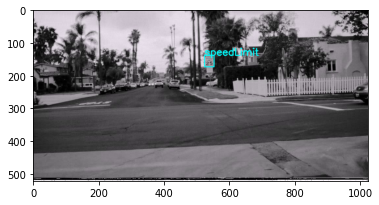

In [27]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

# Generate random index
rng = np.random.randint(0, len(training_data))

# Get annotation
annotation = training_data[rng]
im = cv.imread(annotation.filename)

# Draw bounding box
def show_annotation(im, annotation):  
    height, width, channels = im.shape
    x,y,w,h = annotation.bounds
    left = int((float(x) - float(w)/2)*width)
    top = int((float(y) - float(h)/2)*height)
    right = int((float(x) + float(w)/2)*width)
    bot = int((float(y) + float(h)/2)*height)
    cv.rectangle(im, (left, top), (right, bot), (255, 255, 0), 2)

    cv.putText(im,annotation.label,(left,top), cv.FONT_HERSHEY_SIMPLEX,\
           1, (255, 255, 0), 2, cv.LINE_AA)

    # Display image
    plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB));
    
show_annotation(im, annotation)
print(annotation)

## Save data
Now that we have our annotations sorted, we need to save and move the images and labels to the correct directories, and generate the yaml descriptor file.

In [28]:
from os.path import join, basename
from pathlib import Path
from IPython.display import clear_output

# Separate annotations by image file
training_image_files = dict()
validation_image_files = dict()

for annotation in training_data:
    if annotation.filename not in training_image_files.keys():
        training_image_files[annotation.filename] = []
    training_image_files[annotation.filename].append(annotation)

for annotation in validation_data:
    if annotation.filename not in validation_image_files.keys():
        validation_image_files[annotation.filename] = []
    validation_image_files[annotation.filename].append(annotation)

# Create directories if they don't exist
train_images_location = join(data_location, 'images', 'train')
train_labels_location = join(data_location, 'labels', 'train')
val_images_location = join(data_location, 'images', 'val')
val_labels_location = join(data_location, 'labels', 'val')
Path(train_images_location).mkdir(parents=True, exist_ok=True)
Path(train_labels_location).mkdir(parents=True, exist_ok=True)
Path(val_images_location).mkdir(parents=True, exist_ok=True)
Path(val_labels_location).mkdir(parents=True, exist_ok=True)
    
# Iterate through each image file, generate label txt file, and save
total_images = len(training_image_files) + len(validation_image_files)
processed = 0

for file in training_image_files:
    clear_output(wait=True)
    
    # Open and save image
    im = Image.open(file)
    filename = '.'.join(basename(file).split('.')[:-1])
    im.save(join(train_images_location, filename + '.jpg'))
    
    # Generate and save label file
    with open(join(train_labels_location, filename + '.txt'), 'w+') as f:
        for annotation in training_image_files[file]:
            f.write(str(annotation) + '\n')
    
    # Update progress
    processed += 1
    print(f'Processed {processed} out of {total_images} images.')
            
for file in validation_image_files:
    clear_output(wait=True)
    
    # Open and save image
    im = Image.open(file)
    filename = '.'.join(basename(file).split('.')[:-1])
    im.save(join(val_images_location, filename + '.jpg'))
    
    # Generate and save label file
    with open(join(val_labels_location, filename + '.txt'), 'w+') as f:
        for annotation in validation_image_files[file]:
            f.write(str(annotation) + '\n')
    
    # Update progress
    processed += 1
    print(f'Processed {processed} out of {total_images} images.')
    
print('Generating configuration file...')
with open(join(data_location, 'traffic.yaml'), 'w+') as f:
    f.write(f'train: {train_images_location}/\n' +
           f'val: {val_images_location}/\n\n' +
           f'nc: {len(classes)}\n\n' +
           f'names: {classes}')
    
print('Completed.')

Processed 2377 out of 2377 images.
Generating configuration file...
Completed.
